In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/bgflow")
import bgflow

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
from bgflow.utils import (assert_numpy, distance_vectors, distances_from_vectors,
                    remove_mean, IndexBatchIterator, LossReporter)

from bgflow import (GaussianMCMCSampler, SequentialFlow, BoltzmannGenerator, 
                    Energy, Sampler, MultiDoubleWellPotential, MeanFreeNormalDistribution, 
                    CouplingFlow, AffineTransformer, DenseNet, 
                    SequentialFlow, SwapFlow, SplitFlow, InverseFlow )
from bgflow.utils import RbfEncoder, kernelize_with_rbf, compute_gammas, as_numpy, compute_distances


In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = torch.zeros([], device=device, dtype=dtype)

# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")

In [5]:
fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.*.lammpstrj')
#fnames = fnames + glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T0.700_P0.0000020000.lammpstrj')
#fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.0000000000.lammpstrj')
arrays = [np.loadtxt(f, skiprows=9)[:,2:5] for f in fnames]
coordinates = np.array(arrays)
temperature = float(1.00)
side=3.
dim = len(coordinates)
n_particles = len(coordinates[0])
spacial_dim = 3
dim_ics = n_particles * spacial_dim
coordinates=coordinates.reshape(len(arrays), dim_ics)

In [6]:
from  bgflow.distribution.energy import LennardJonesPotentialPPP
rm = 2**(1./6.)
target = LennardJonesPotentialPPP(dim = dim_ics, n_particles = n_particles, side = side, oscillator = False, rm=rm, two_event_dims=False)

In [7]:
def plot_energy(coordinates, target):
    xs = torch.Tensor(coordinates)
    #xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    x=np.arange(1,len(energy)+1)

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)

In [8]:
def save_energy(coordinates, target, step):
    xs = torch.Tensor(coordinates)
    #xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    x=np.arange(1,len(energy)+1)

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)
    
    filename = '/home/ninarell/Desktop/FIG_ENERGY/fig_'+str(step)+".png"
    fig.savefig(filename, dpi=fig.dpi, format='png')
    plt.close()

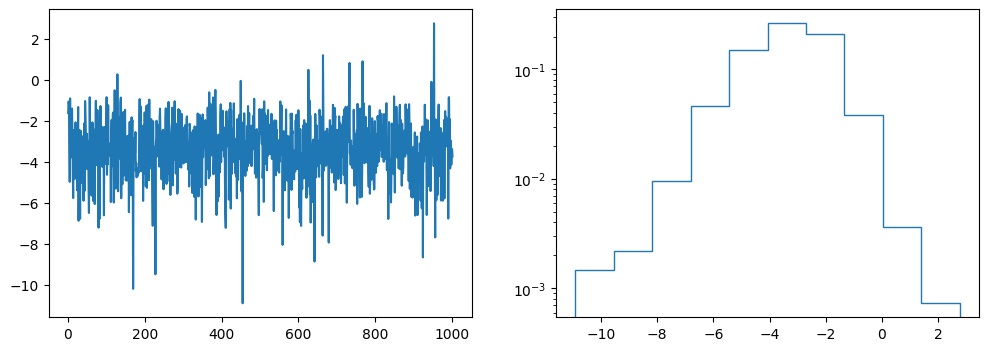

In [9]:
plot_energy(coordinates, target)

In [10]:
from bgflow import NormalDistribution, TruncatedNormalDistribution

mean = torch.Tensor(coordinates[10]).view(dim_ics)
cov = torch.zeros(dim_ics, dim_ics)
cov = cov.fill_diagonal_(0.001)

prior = NormalDistribution(dim_ics, mean=mean, cov=cov)

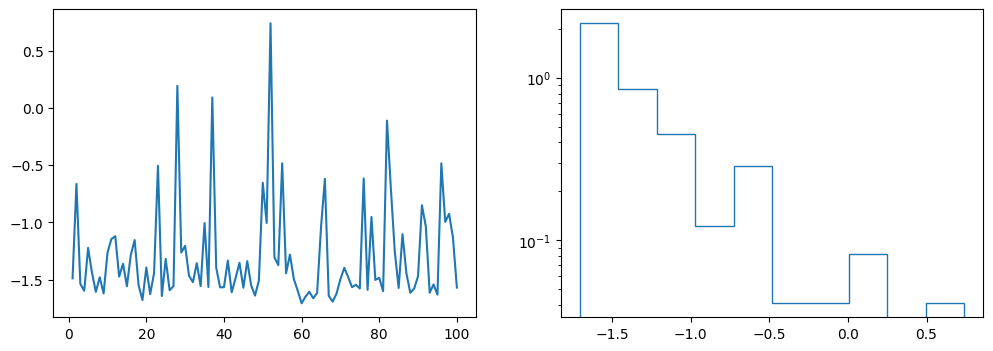

In [11]:
data_prior = prior._sample_with_temperature(100, temperature=temperature)
plot_energy(data_prior, target)

In [12]:
def constraint(x):
    return torch.where((abs(x) > side).clone().detach(), x - 2 * side * torch.sign(x) * torch.floor(abs(x)/side), x)

In [13]:
init_state = torch.Tensor(coordinates[10]) #zeros(10,3)

mcsampler = GaussianMCMCSampler(target, init_state=init_state, temperature=temperature, box_constraint=constraint, noise_std=0.15)
data = mcsampler.sample(10000)
data = data.view(-1,dim_ics)

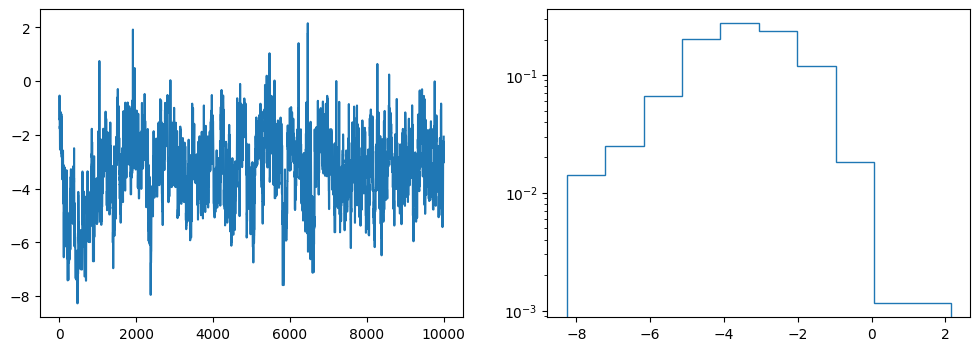

In [14]:
plot_energy(data, target)

In [15]:
# The equivaraint RNVP flow requires and invaraint scaling transformation 
# and an equivaraint translation transformation. Both wrt to rotations and permutations

class InvariantNet(torch.nn.Module):    
    def __init__(self, n_particles, n_dof, dist_net, encoder=None):
        super().__init__()
        self._dist_net = dist_net
        self._encoder = encoder
        self._n_particles = n_particles
        self._n_dof = n_dof    
    def forward(self, x):
        n_batch = x.shape[0]
        n_dim = self._n_particles * self._n_dof
        assert x.shape[-1] == n_dim
        x = x.view(n_batch, self._n_particles, self._n_dof)
        r = distance_vectors(x) 
        d = distances_from_vectors(r)
        if self._encoder is not None:
            d = self._encoder(d.unsqueeze(-1))
        d_shape = d.shape
        f = self._dist_net(d.view(-1, d_shape[-1]))
        f = f.view(*d_shape[:-1], -1)
        f = f.view(n_batch, -1).mean(dim=-1, keepdim=True) * torch.ones(n_batch, n_dim) #.cuda()
        return f
    
class EquivariantNet(torch.nn.Module):          
    def __init__(self, n_particles, n_dof, dist_net, encoder=None, remove_mean=True):
        super().__init__()
        self._dist_net = dist_net
        self._encoder = encoder
        self._invariant_net = dist_net
        self._n_particles = n_particles
        self._n_dof = n_dof
        self._remove_mean = remove_mean  
        
    def forward(self, x):
        n_batch = x.shape[0]
        x = x.view(n_batch, self._n_particles, self._n_dof)
        r = distance_vectors(x) 
        dist = distances_from_vectors(r)
        r = r / (dist.unsqueeze(-1) + 1e-3)
        if self._encoder is not None:
            d = self._encoder(dist.unsqueeze(-1)) 
        d_shape = d.shape
        f = self._dist_net(d.view(-1, d_shape[-1]))
        f = f.view(*d_shape[:-1], -1) #+ q
        f = (f * r).sum(dim=-2)
        if self._remove_mean:
            f = remove_mean(f, self._n_particles, self._n_dof)
        return f.view(n_batch, -1)

In [16]:
# Now we can define the equivariant RNVP flow



n_rbfs = 50
n_layers = 4

# shared distance embeddings across RNVP blocs 
kernel_mus = torch.linspace(0., 8., n_rbfs)#.cuda()
kernel_gammas = compute_gammas(kernel_mus, gain=0.5)#.cuda()
dist_encoder = RbfEncoder(kernel_mus, kernel_gammas.log(), trainable=True)

layers=[]

layers.append(SplitFlow( dim_ics , dim=1))

n_coupling_layers = 16
for _ in range(n_coupling_layers):
    
    # we need to swap dimensions for the mixing
    layers.append(SwapFlow())
    
    # now set up a coupling block
    layers.append(CouplingFlow(
        AffineTransformer(
                EquivariantNet(
                    n_particles, spacial_dim, DenseNet([n_rbfs, 200, 200, 1], torch.nn.ReLU()),
                    encoder=dist_encoder
                ),
                InvariantNet(
                    n_particles, spacial_dim, DenseNet([n_rbfs, 200, 200, 1], torch.nn.ReLU()),
                    encoder=dist_encoder
                ),

            )
        )
    )
    
# finally, we have to merge the two channels again into one tensor
layers.append(InverseFlow(SplitFlow( dim_ics , dim=1)))
    
# now define the flow as a sequence of all operations stored in layers
flow = SequentialFlow(layers) #.cuda()

In [17]:
# having a flow and a prior, we can now define a Boltzmann Generator


bg = BoltzmannGenerator(prior, flow, target)

In [18]:
# train with convex mixture of NLL and KL loss

n_kl_samples = 50
n_batch = 50
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-4)

n_epochs = 5
n_report_steps = 50

# mixing parameter
lambdas = torch.linspace(1., 0.0, n_epochs)#.cuda()

reporter = LossReporter("NLL", "KLL")

2024-05-16 18:00:05.657441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 18:00:05.657470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 18:00:05.658766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 18:00:05.663532: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 18:00:06.295722: W tensorflow/compiler/tf2

In [24]:
for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch_data = data[idxs] #.cuda()
        #print(batch_data.shape)
        #print(prior.sample(batch_data.shape[0]).shape)
        batch_noise = prior.sample(batch_data.shape[0])#.view(-1, dim)
        batch = torch.cat([batch_data, batch_noise], dim=1)
        
        optim.zero_grad()

        # negative log-likelihood of the batch is equal to the energy of the BG

        latent_samples, latent_dlogp = flow(batch, inverse=True)
        nll = - 0.5 * latent_dlogp.mean() + prior.energy(latent_samples[:, dim_ics:]).mean() + prior.energy(latent_samples[:, :dim_ics]).mean()  
        (lamb*nll).backward()
        
        # kl divergence to the target
        latent = torch.cat([prior.sample(n_kl_samples), prior.sample(n_kl_samples)], dim=1)
        samples, dlogp = flow(latent)

        kll = target.energy(samples[:, :dim_ics]).mean() + prior.energy(samples[:, dim_ics:]).mean() - 0.5 *  dlogp.mean()   

        # aggregate weighted gradient
        ((1. - lamb) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")
    n_samples=100
    latent = torch.cat([prior.sample(n_samples), prior.sample(n_samples)], dim=1)
    samples, dlogp = flow(latent)
    save_energy(samples[:, :dim_ics], target, str(epoch)+"_"+str(lamb))


IndexError: tuple index out of range

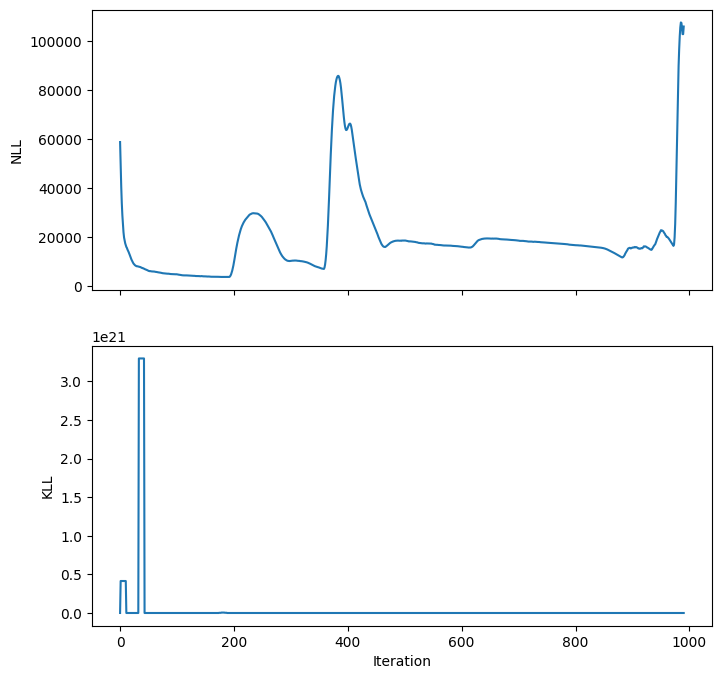

In [20]:
reporter.plot()

In [21]:
n_samples = 1000

latent = torch.cat([prior.sample(n_samples), prior.sample(n_samples)], dim=1)
samples, dlogp = flow(latent)

distances_x = as_numpy(compute_distances(samples[:, :dim_ics], n_particles, dim_ics // n_particles))
distances_v = as_numpy(compute_distances(samples[:, dim_ics:], n_particles, dim_ics // n_particles))

log_w = target.energy(samples[:, :dim_ics]) + prior.energy(samples[:, dim_ics:]) - 0.5 * dlogp  - prior.energy(latent[:, dim_ics:]) - prior.energy(latent[:, :dim_ics]) 
log_w = as_numpy(log_w)


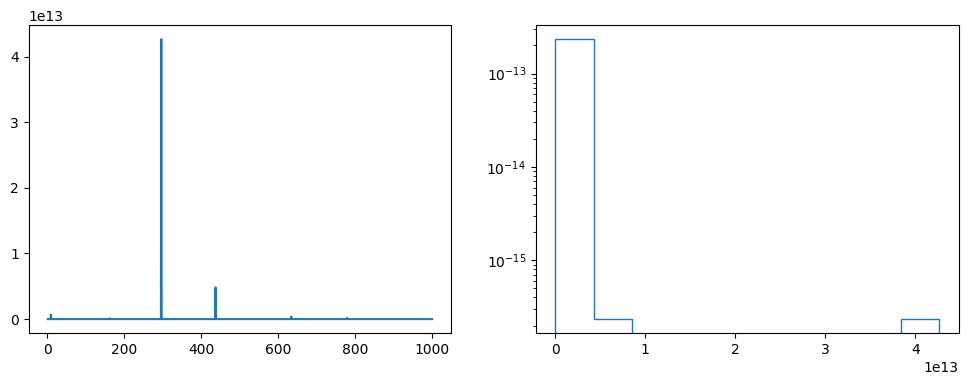

In [23]:
plot_energy(samples[:, :dim_ics], target)